# CLIPasso応用_感情認識_スケッチ画像
**概要**    
・FER-2013データセットからCLIPassoで生成したスケッチ画像を使って感情認識を行うことで、CLIPassoの特徴である意味（ここでは顔画像における表情、感情と定義して）の認識について検証を行うことを目指した  
・表情のスケッチ画像から[happy, natural, angry, sad]の4つの感情を認識をする  
・VGG16への転移学習を行う  
・trainデータ、validationデータ、testデータにそれぞれの感情ごとに事前にスケッチ生成とフォルダ分割が必要    
・学習結果（trainとvalのloss表示）とテストデータでの認識結果を示す  

**リファレンス**  
[「少ないデータで転移学習を用いて画像内の表情を分類する」](https://github.com/zarakima/face-classification)   
[FER-2013](https://www.kaggle.com/datasets/msambare/fer2013)  
[CLIPasso](https://clipasso.github.io/clipasso/)

## データセットの準備  

・各クラスごとに学習(train)420枚/バリデーション(validation)/予測(test)150枚で分割。（プレーン画像と同じ元画像、同データ数使用）  
・FER-2013のtrainをtrainに、testフォルダをtestとvalidationに使用。   
・Google driveに以下のディレクトリ構成

```
sketched_dataset
├── train
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── angry
├── validation
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── angry
└── test
    ├── happy
    ├── neutral
    ├── sad
    └── angry
```

## Google drive連携

In [1]:
# datasetディレクトリ
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utilsコード

In [2]:
# # google drivenのファイル数カウントに使用
# import os
 
# # ファイル数を調べたいフォルダのパス
# path = '/content/drive/Shareddrives/SketchWorldModels/plain_datasets/train/sad'
 
# # フォルダ内の全ファイル名をリスト化
# files = os.listdir(path)

# path2 = '/content/drive/Shareddrives/SketchWorldModels/emotionclassification/plain_datasets/train/sad'
# files2 = os.listdir(path2)

# # for i in files:
# #   if i not in files2:
# #     print(i)
 
# # リストの長さ（ファイル数）を取得
# count = len(files)
# count2 = len(files2)
 
# # ファイル数を確認
# print(count)
# print(count2)

## 必要なライブラリのインポート

In [3]:
import os
import sys
import glob

import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import optimizers
from keras.layers import Dense, Flatten, Input, Activation, add
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# 学習済みネットワーク
from keras.applications.vgg16 import VGG16\

## ハイパーパラメータの設定

In [4]:
# 分類
emotions = ['happy', 'neutral', 'angry', 'sad'] # 分類したい項目名（ディレクトリ名）
emotion_count = len(emotions)

image_width, image_height = 150, 150

dataset_path = '/content/drive/Shareddrives/SketchWorldModels/emotionclassification/sketched_datasets'

train_data_path = str(dataset_path) + '/train' 
validation_data_path = str(dataset_path) + '/validation' 
test_data_path = str(dataset_path) + '/test' 

# 重みデータを保存するディレクトリ
result_dir = '/content/drive/Shareddrives/SketchWorldModels/emotionclassification'
# 重みデータのファイル名 (.h5に注意)
weights_file = 'weights_sketched.h5'

# データの枚数
train_data_count = 420
validation_data_count = 140

# バッチサイズ、エポック数
batch_size = 8
epoch_count = 50

## データの生成（ジェネレータ）

In [5]:
# データ生成
datagen = ImageDataGenerator(
    rescale = 1.0/255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.39,
    horizontal_flip=True,
    samplewise_center=False,
    samplewise_std_normalization =False,
    zca_whitening=False)

In [6]:
generator_train = datagen.flow_from_directory(
    train_data_path,
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=emotions,
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=True)

generator_validation = datagen.flow_from_directory(
    validation_data_path, 
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=emotions,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

Found 1680 images belonging to 4 classes.
Found 580 images belonging to 4 classes.


## 学習済みVGG16の読み込みと全結合層の作成

In [7]:
# VGG16学習済みモデルの読み込み(RGB)
input_tensor = Input(shape=(image_width, image_height, 3))
learned_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 全結合層の作成
full_model = Sequential()
full_model.add(Flatten(input_shape=learned_model.output_shape[1:]))
full_model.add(Dense(256, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(64, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(emotion_count, activation='softmax'))

# 学習済みデータと全結合層を結合
model = Model(inputs=learned_model.input, outputs=full_model(learned_model.output))

# 全結合層直前までの層を学習しないようにする
for layer in learned_model.layers[:15]:
    layer.trainable = False

# 学習処理の設定
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=optimizers.gradient_descent_v2.SGD(learning_rate=1e-3, momentum=0.9),
    metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step


## 学習
・実行時間はGoogle Clab Pro GPU/High-RAMで15分ほど

In [8]:
# 学習
result = model.fit(
    generator_train,
    steps_per_epoch=train_data_count // batch_size,
    epochs=epoch_count,
    validation_data=generator_validation,
    validation_steps=validation_data_count // batch_size)

# 重みを保存
model.save_weights(os.path.join(result_dir, weights_file))

Epoch 1/50
52/52 [==============================] - 170s 3s/step - loss: 1.4505 - accuracy: 0.2788 - val_loss: 1.4010 - val_accuracy: 0.2426
Epoch 2/50
52/52 [==============================] - 125s 2s/step - loss: 1.3897 - accuracy: 0.2716 - val_loss: 1.4034 - val_accuracy: 0.2132
Epoch 3/50
52/52 [==============================] - 90s 2s/step - loss: 1.3756 - accuracy: 0.2957 - val_loss: 1.4043 - val_accuracy: 0.2500
Epoch 4/50
52/52 [==============================] - 67s 1s/step - loss: 1.3782 - accuracy: 0.2957 - val_loss: 1.3697 - val_accuracy: 0.2868
Epoch 5/50
52/52 [==============================] - 57s 1s/step - loss: 1.3260 - accuracy: 0.3341 - val_loss: 1.2684 - val_accuracy: 0.3824
Epoch 6/50
52/52 [==============================] - 38s 744ms/step - loss: 1.3276 - accuracy: 0.3558 - val_loss: 1.3362 - val_accuracy: 0.4044
Epoch 7/50
52/52 [==============================] - 29s 559ms/step - loss: 1.3404 - accuracy: 0.3269 - val_loss: 1.2926 - val_accuracy: 0.3971
Epoch 8/50
5

## 学習結果の表示

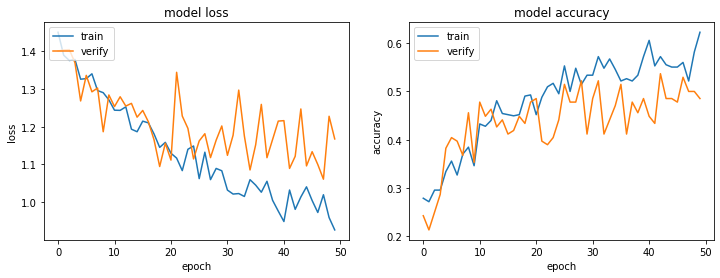

In [9]:
fig = plt.figure(figsize=(12,4))

# subplot
# loss
sub_loss = fig.add_subplot(1,2,1)
sub_loss.plot(result.history['loss'])
sub_loss.plot(result.history['val_loss'])
sub_loss.set_title('model loss')
sub_loss.set_ylabel('loss')
sub_loss.set_xlabel('epoch')
sub_loss.legend(['train', 'verify'], loc='upper left')

#Accuracy
sub_acc = fig.add_subplot(1,2,2)
sub_acc.plot(result.history['accuracy'])
sub_acc.plot(result.history['val_accuracy'])
sub_acc.set_title('model accuracy')
sub_acc.set_ylabel('accuracy')
sub_acc.set_xlabel('epoch')
sub_acc.legend(['train', 'verify'], loc='upper left')

## テストデータでの予測

In [10]:
def test_predict(filepath_list):
    
    # 各クラスの予測画像枚数
    num_test = 5

    count = 0
    for i in filepath_list:
        # 画像を読み込んで4次元テンソルへ変換
        img = image.load_img(i, target_size=(image_height, image_width))
        xarray = image.img_to_array(img)
        x = np.expand_dims(xarray, axis=0)
        # テストデータも正規化
        x = x / 255.0

        # 予測 入力は1枚の画像なので[0]のみ
        pred = model.predict(x)[0]
        
        # 描画 topの数だけ予測確率が高い結果を出力
        fig = plt.figure(figsize=(2,2))
        top = 3
        top_indices = pred.argsort()[-top:][::-1]
        result = [(emotions[i], pred[i]) for i in top_indices]
        [print(x) for x in result]
        plt.imshow(img)
        plt.show()
        
        print('------------------------------------')

        count += 1
        if count == num_test: break



<<HAPPY>>

('happy', 0.8139169)
('sad', 0.079674035)
('neutral', 0.057109736)


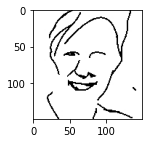

------------------------------------
('neutral', 0.5930398)
('sad', 0.23321898)
('happy', 0.106907524)


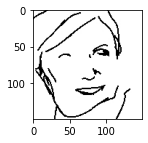

------------------------------------
('neutral', 0.46292657)
('happy', 0.36376342)
('sad', 0.11568152)


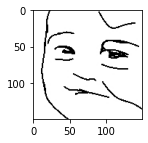

------------------------------------
('happy', 0.5302944)
('sad', 0.26187727)
('angry', 0.13571666)


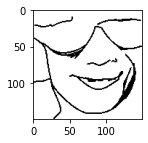

------------------------------------
('neutral', 0.6320452)
('sad', 0.21131206)
('angry', 0.09619062)


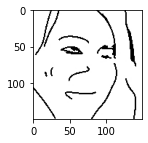

------------------------------------


<<NEUTRAL>>

('sad', 0.5762487)
('neutral', 0.2918666)
('angry', 0.09433394)


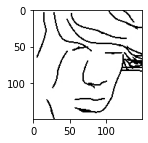

------------------------------------
('happy', 0.38871232)
('neutral', 0.31597316)
('sad', 0.20696057)


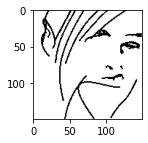

------------------------------------
('happy', 0.63739574)
('neutral', 0.22032356)
('sad', 0.09801256)


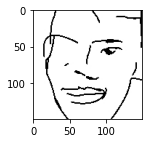

------------------------------------
('sad', 0.4875846)
('angry', 0.25667387)
('neutral', 0.15878782)


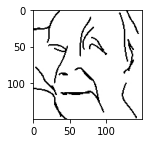

------------------------------------
('sad', 0.5634548)
('neutral', 0.3469677)
('angry', 0.07531192)


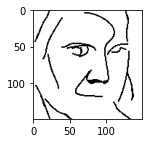

------------------------------------


<<ANGRY>>

('angry', 0.48655364)
('sad', 0.44908684)
('neutral', 0.052003726)


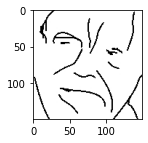

------------------------------------
('angry', 0.83439356)
('sad', 0.15640764)
('neutral', 0.0081083905)


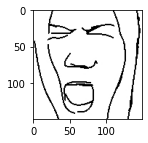

------------------------------------
('angry', 0.85051703)
('sad', 0.11092403)
('happy', 0.03146623)


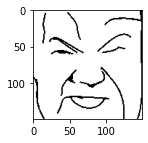

------------------------------------
('sad', 0.5714281)
('angry', 0.31716156)
('neutral', 0.10561603)


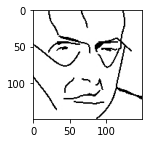

------------------------------------
('sad', 0.3531051)
('neutral', 0.25156564)
('angry', 0.23040253)


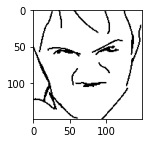

------------------------------------


<<SAD>>

('sad', 0.6813254)
('angry', 0.21793696)
('neutral', 0.09490408)


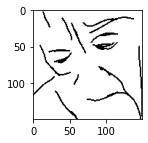

------------------------------------
('neutral', 0.61671853)
('sad', 0.21269438)
('angry', 0.15405998)


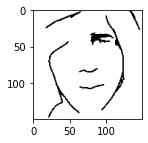

------------------------------------
('neutral', 0.40423378)
('sad', 0.24466923)
('angry', 0.22376157)


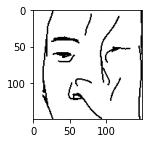

------------------------------------
('neutral', 0.48895615)
('sad', 0.42313954)
('angry', 0.0765199)


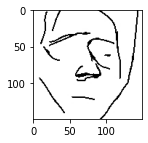

------------------------------------
('neutral', 0.53646743)
('sad', 0.3323576)
('angry', 0.11951651)


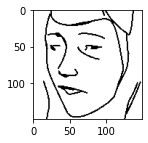

------------------------------------


In [11]:
for x in emotions:
    print('\n\n<<'+ str(x).upper() + '>>\n')
    filepath_list = glob.glob(str(test_data_path)  + '/' + str(x) + '/*')
    test_predict(filepath_list)